In [2]:
###############################
# Imports
###############################
import math
import random
from collections import namedtuple, deque
from itertools import count
from datetime import datetime

import gymnasium as gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# set up matplotlib
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

plt.ion()

# GPU 
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"
)
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("Training on CPU.")

GPU: NVIDIA GeForce GTX 1060 6GB is available.


In [3]:
render = False
env = gym.make("CartPole-v1", render_mode="human") if render else gym.make("CartPole-v1")

In [4]:
###############################
# DQN
###############################
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, n_actions)

    # Call with one elem or batch.
    # Returns tensor([[left0exp,right0exp],...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

###############################
# Replay Buffer
###############################
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayBuffer(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity) # auto popleft if capacity reached

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
###############################
# Utilities: select_action(state) and plot_durations()
###############################

BATCH_SIZE = 128 # number of transitions sampled from the replay buffer
GAMMA = 0.99 # discount factor
EPS_START = 0.9 # probability of choosing random action
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005 # update rate
LR = 1e-4 # learning rate of AdamW optimizer

# Number of actions
n_actions = env.action_space.n
# Number of state obs
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict()) # copy weights

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayBuffer(10000)


steps_done = 0

def select_action(state):
    global steps_done
    steps_done += 1

    # Calculate epsilon threshold
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1.0 * steps_done / EPS_DECAY)
    rand = random.random()

    if rand > eps_threshold:
        # Exploitation
        with torch.no_grad():
            action = policy_net(state).max(1).indices.view(1, 1)
    else:
        # Exploration: choose random action
        action = torch.tensor(
            [[env.action_space.sample()]], device=device, dtype=torch.long
        )

    return action


episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause to update plot
    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())

In [6]:
###############################
# Perform one step of gradient descent
###############################

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a)
    state_action_values = policy_net(state_batch).gather(1, action_batch) # Compute Q(s_t), then select action

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


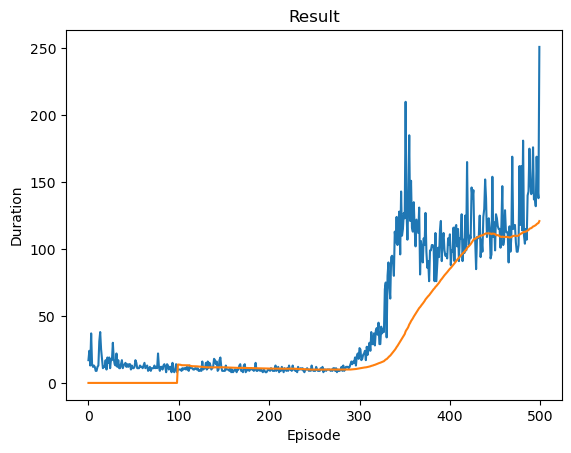

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Time to train:  0:02:13.243378


In [7]:
###############################
# Training!
# The model pushes a new (state, action, next_state, reward) pair onto the memory, and each step samples a batch from memory to train the network. 
###############################

if torch.cuda.is_available():
    num_episodes = 500
else:
    num_episodes = 500

startTime = datetime.now()

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store transition, optimize, and move to next state
        memory.push(state, action, next_state, reward)
        optimize_model()
        state = next_state

        # Soft update of target network
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

print("Time to train: ", datetime.now() - startTime)

In [ ]:
# ###############################
# # Save Model
# ###############################
# PATH = "cartpole_model"
# torch.save(policy_net.state_dict(), PATH)     

In [ ]:
# ###############################
# # Load Model 
# ###############################
# PATH = "cartpole_model"
# policy_net = DQN(n_observations, n_actions).to(device)
# policy_net.load_state_dict(torch.load(PATH, weights_only=True))
# policy_net.eval()

DQN(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=2, bias=True)
)

In [13]:
###############################
# Visualize Performance
###############################
import time

env = gym.make("CartPole-v1", render_mode="human")
state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

while True:
    env.render()
    action = policy_net(state).max(1).indices.view(1, 1)
    observation, reward, terminated, truncated, _ = env.step(action.item())
    next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


    done = terminated or truncated

    if terminated:
        next_state = None
    else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    
    state = next_state

    if done:
        break
    time.sleep(0.1)  # Add a delay to make the visualization easier to follow

env.close()

NameError: name 'time' is not defined